In [20]:
import random
import math

from graphviz import Digraph
import torch

In [50]:
class Value:
    def __init__(self, data, _children=(), _op='', label='' ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
 
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
          self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
 

In [43]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [44]:
# .double to  float64
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [45]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]


class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.32894353367263374)

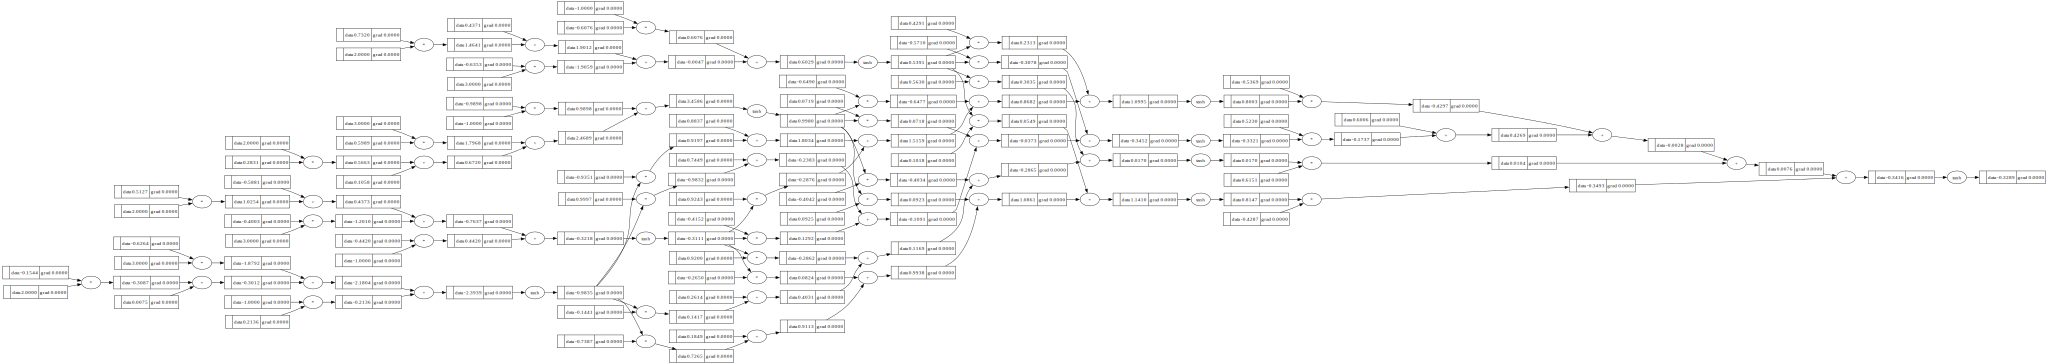

In [47]:
draw_dot(n(x))

In [67]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [68]:
ypred = [n(x) for x in xs]
ypred
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [73]:
for k in range(30):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.002942537660378505
1 0.0029275231198114867
2 0.0029126515904513975
3 0.0028979210910542352
4 0.0028833296762770895
5 0.002868875435876265
6 0.0028545564939267748
7 0.0028403710080622396
8 0.002826317168735047
9 0.0028123931984955
10 0.002798597351290152
11 0.0027849279117779444
12 0.0027713831946643845
13 0.0027579615440526273
14 0.0027446613328112246
15 0.0027314809619580637
16 0.002718418860059957
17 0.002705473482647407
18 0.0026926433116441027
19 0.0026799268548108077
20 0.002667322645203171
21 0.002654829240642878
22 0.0026424452232021644
23 0.0026301691987008794
24 0.0026179997962160347
25 0.002605935667603324
26 0.0025939754870303393
27 0.0025821179505211896
28 0.002570361775512067
29 0.0025587057004176125


In [74]:
ypred

[Value(data=0.9769703656517955),
 Value(data=-0.9649569859313185),
 Value(data=-0.9819610492843636),
 Value(data=0.9782072244937309)]

In [75]:
n.parameters()

[Value(data=-0.5661991835672925),
 Value(data=-0.32126721670668973),
 Value(data=-0.39113673874530486),
 Value(data=-0.12489512308742157),
 Value(data=0.6568801734637661),
 Value(data=-0.1908872785750798),
 Value(data=-0.6023249336342229),
 Value(data=-0.5673379904194911),
 Value(data=-0.09671497849855211),
 Value(data=0.5841998009430198),
 Value(data=-1.3069229484786602),
 Value(data=-0.14840814873734526),
 Value(data=0.5455586221862626),
 Value(data=-0.9003504374302855),
 Value(data=-0.5388868430364134),
 Value(data=0.24975596956672796),
 Value(data=0.7560734968575135),
 Value(data=-0.2799663187347588),
 Value(data=1.1087964549954121),
 Value(data=-0.4491806972235827),
 Value(data=0.8659737703074126),
 Value(data=-0.7186651011450234),
 Value(data=0.6161581549398558),
 Value(data=-1.1041692185585683),
 Value(data=0.22249283561205624),
 Value(data=0.698630432071323),
 Value(data=-0.31139329788422343),
 Value(data=1.2559600697545905),
 Value(data=0.24683946699064035),
 Value(data=0.9079